## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## Load the dataset

In [2]:
data = pd.read_csv("CMC_BTC.csv")

In [3]:
data.head()

,Date,Last,diff_24h,diff_per_24h,Open,High,Low,Close,Volume
0,2019/1/4,3836.74,20.98,0.546818,3832.04,3865.93,3783.85,3857.72,4847965467
1,2019/1/5,3857.72,-12.53,-0.324803,3851.97,3904.90,3836.90,3845.19,5137609824
2,2019/1/6,3845.19,231.44,6.018948,3836.52,4093.30,3826.51,4076.63,5597027440
3,2019/1/7,4076.63,-51.38,-1.260355,4078.59,4092.61,4020.89,4025.25,5228625637
4,2019/1/8,4025.25,5.60,0.139122,4028.47,4109.02,3996.96,4030.85,5306593305


In [4]:
#data['Date'].value_counts()

## Subset USD

In [5]:
#df = data.loc[(data['rpt_key'] == 'btc_usd')]
df = data

In [6]:
df.head()

,Date,Last,diff_24h,diff_per_24h,Open,High,Low,Close,Volume
0,2019/1/4,3836.74,20.98,0.546818,3832.04,3865.93,3783.85,3857.72,4847965467
1,2019/1/5,3857.72,-12.53,-0.324803,3851.97,3904.90,3836.90,3845.19,5137609824
2,2019/1/6,3845.19,231.44,6.018948,3836.52,4093.30,3826.51,4076.63,5597027440
3,2019/1/7,4076.63,-51.38,-1.260355,4078.59,4092.61,4020.89,4025.25,5228625637
4,2019/1/8,4025.25,5.60,0.139122,4028.47,4109.02,3996.96,4030.85,5306593305


### Convert datetime_id to data type and filter dates greater than  2017-06-28 00:00:00

In [7]:
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['Date'] > pd.to_datetime('2019-01-04')]

In [8]:
#df = df[['Date', 'Last', 'diff_24h', 'diff_per_24h', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [9]:
#df.head()

### we require only the last value, so we subset that and convert it to numpy array

In [10]:
df = df[['Last']]

In [11]:
dataset = df.values
dataset = dataset.astype('float32')

In [12]:
dataset

array([[ 3857.72],
       [ 3845.19],
       [ 4076.63],
       [ 4025.25],
       [ 4030.85],
       [ 4035.3 ],
       [ 3678.92],
       [ 3687.37],
       [ 3661.3 ],
       [ 3552.95],
       [ 3706.05],
       [ 3630.68],
       [ 3655.01],
       [ 3678.56],
       [ 3657.84],
       [ 3728.57],
       [ 3601.01],
       [ 3576.03],
       [ 3604.58],
       [ 3585.12],
       [ 3600.87],
       [ 3599.77],
       [ 3602.46],
       [ 3583.97],
       [ 3470.45],
       [ 3448.12],
       [ 3486.18],
       [ 3457.79],
       [ 3487.95],
       [ 3521.06],
       [ 3464.01],
       [ 3459.15],
       [ 3466.36],
       [ 3413.77],
       [ 3399.47],
       [ 3666.78],
       [ 3671.2 ],
       [ 3690.19],
       [ 3648.43],
       [ 3653.53],
       [ 3632.07],
       [ 3616.88],
       [ 3620.81],
       [ 3629.79],
       [ 3673.84],
       [ 3915.71],
       [ 3947.09],
       [ 3999.82],
       [ 3954.12],
       [ 4005.53],
       [ 4142.53],
       [ 3810.43],
       [ 388

Neural networks are sensitive to input data, especiallly when we are using activation functions like sigmoid or tanh activation functions are used. ISo we rescale our data to the range of 0-to-1, using MinMaxScaler

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [14]:
dataset

array([[0.04765117],
       [0.04634824],
       [0.07041457],
       [0.06507182],
       [0.06565413],
       [0.06611687],
       [0.02905864],
       [0.02993733],
       [0.02722645],
       [0.01595965],
       [0.03187978],
       [0.0240424 ],
       [0.02657238],
       [0.02902123],
       [0.02686664],
       [0.03422153],
       [0.02095717],
       [0.01835963],
       [0.02132839],
       [0.01930487],
       [0.02094263],
       [0.02082822],
       [0.02110794],
       [0.01918525],
       [0.00738087],
       [0.00505888],
       [0.00901654],
       [0.00606441],
       [0.0092006 ],
       [0.01264358],
       [0.00671121],
       [0.00620583],
       [0.00695559],
       [0.00148699],
       [0.        ],
       [0.02779627],
       [0.02825588],
       [0.03023055],
       [0.02588814],
       [0.02641848],
       [0.02418694],
       [0.02260739],
       [0.02301607],
       [0.02394986],
       [0.02853042],
       [0.05368128],
       [0.05694434],
       [0.062

In [15]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test, feed = dataset[0:train_size, :], dataset[train_size:len(dataset), :], dataset[train_size:len(dataset), :]
print(len(train), len(test), len(feed))

243 120 120


Now let us define the function called create_dataset, which take two inputs, 

1. Dataset - numpy array that we want to convert into a dataset
2. look_back - number of previous time steps to use as input variables to predict the next time period


In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [17]:
look_back = 7
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [18]:
trainX

array([[0.04765117, 0.04634824, 0.07041457, ..., 0.06565413, 0.06611687,
        0.02905864],
       [0.04634824, 0.07041457, 0.06507182, ..., 0.06611687, 0.02905864,
        0.02993733],
       [0.07041457, 0.06507182, 0.06565413, ..., 0.02905864, 0.02993733,
        0.02722645],
       ...,
       [0.7029904 , 0.70076084, 0.7249167 , ..., 0.66082025, 0.63542503,
        0.64457256],
       [0.70076084, 0.7249167 , 0.70564616, ..., 0.63542503, 0.64457256,
        0.647951  ],
       [0.7249167 , 0.70564616, 0.66082025, ..., 0.64457256, 0.647951  ,
        0.6611893 ]], dtype=float32)

In [19]:
trainY

array([0.02993733, 0.02722645, 0.01595965, 0.03187978, 0.0240424 ,
       0.02657238, 0.02902123, 0.02686664, 0.03422153, 0.02095717,
       0.01835963, 0.02132839, 0.01930487, 0.02094263, 0.02082822,
       0.02110794, 0.01918525, 0.00738087, 0.00505888, 0.00901654,
       0.00606441, 0.0092006 , 0.01264358, 0.00671121, 0.00620583,
       0.00695559, 0.00148699, 0.        , 0.02779627, 0.02825588,
       0.03023055, 0.02588814, 0.02641848, 0.02418694, 0.02260739,
       0.02301607, 0.02394986, 0.02853042, 0.05368128, 0.05694434,
       0.06242749, 0.05767536, 0.06302124, 0.07726717, 0.04273373,
       0.05024874, 0.0473018 , 0.04695761, 0.0473465 , 0.04784462,
       0.04834789, 0.04655519, 0.03765199, 0.05167124, 0.05245736,
       0.05324143, 0.05216518, 0.05863097, 0.05741331, 0.05259153,
       0.05300018, 0.05274644, 0.05458182, 0.05838141, 0.06751338,
       0.06506974, 0.06582674, 0.0698489 , 0.0715428 , 0.06549609,
       0.06493872, 0.06617197, 0.06475154, 0.05860603, 0.06089

In [20]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Build our Model

In [21]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=256, verbose=2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300
 - 1s - loss: 0.2432
Epoch 2/300
 - 0s - loss: 0.2400
Epoch 3/300
 - 0s - loss: 0.2368
Epoch 4/300
 - 0s - loss: 0.2336
Epoch 5/300
 - 0s - loss: 0.2304
Epoch 6/300
 - 0s - loss: 0.2272
Epoch 7/300
 - 0s - loss: 0.2240
Epoch 8/300
 - 0s - loss: 0.2208
Epoch 9/300
 - 0s - loss: 0.2177
Epoch 10/300
 - 0s - loss: 0.2146
Epoch 11/300
 - 0s - loss: 0.2114
Epoch 12/300
 - 0s - loss: 0.2083
Epoch 13/300
 - 0s - loss: 0.2052
Epoch 14/300
 - 0s - loss: 0.2022
Epoch 15/300
 - 0s - loss: 0.1991
Epoch 16/300
 - 0s - loss: 0.1961
Epoch 17/300
 - 0s - loss: 0.1930
Epoch 18/300
 - 0s - loss: 0.1900
Epoch 19/300
 - 0s - loss: 0.1871
Epoch 20/300
 - 0s - loss: 0.1841
Epoch 21/300
 - 0s - loss: 0.1811
Epoch 22/300
 - 0s - loss: 0.1782
Epoch 23/300
 - 0s - loss: 0.1753
Epoch 24/300
 - 0s - loss: 0.1724
Epoch 25/300
 - 0s - loss: 0.1695
Epoch 26/300
 - 0s - loss: 0.1667
Epoch 27/300
 - 0s - loss

Epoch 191/300
 - 0s - loss: 0.0082
Epoch 192/300
 - 0s - loss: 0.0082
Epoch 193/300
 - 0s - loss: 0.0081
Epoch 194/300
 - 0s - loss: 0.0081
Epoch 195/300
 - 0s - loss: 0.0080
Epoch 196/300
 - 0s - loss: 0.0080
Epoch 197/300
 - 0s - loss: 0.0080
Epoch 198/300
 - 0s - loss: 0.0079
Epoch 199/300
 - 0s - loss: 0.0079
Epoch 200/300
 - 0s - loss: 0.0078
Epoch 201/300
 - 0s - loss: 0.0078
Epoch 202/300
 - 0s - loss: 0.0078
Epoch 203/300
 - 0s - loss: 0.0077
Epoch 204/300
 - 0s - loss: 0.0077
Epoch 205/300
 - 0s - loss: 0.0077
Epoch 206/300
 - 0s - loss: 0.0076
Epoch 207/300
 - 0s - loss: 0.0076
Epoch 208/300
 - 0s - loss: 0.0076
Epoch 209/300
 - 0s - loss: 0.0075
Epoch 210/300
 - 0s - loss: 0.0075
Epoch 211/300
 - 0s - loss: 0.0075
Epoch 212/300
 - 0s - loss: 0.0074
Epoch 213/300
 - 0s - loss: 0.0074
Epoch 214/300
 - 0s - loss: 0.0074
Epoch 215/300
 - 0s - loss: 0.0073
Epoch 216/300
 - 0s - loss: 0.0073
Epoch 217/300
 - 0s - loss: 0.0073
Epoch 218/300
 - 0s - loss: 0.0072
Epoch 219/300
 - 0s 

In [22]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Further prediction is made here.

In [23]:
Predictdays = 10
Prediction = testPredict
testX2 = testX
for i in range(10):
    appX = np.append(testX2[-1, 0, 1:], Prediction[-1,0])
    appX = np.array([[appX]])
    testX2 = np.append(testX2, appX, axis=0)
    Prediction = model.predict(testX2) 

We have to invert the predictions before calculating error to so that reports will be in same units as our original data

In [24]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Prediction = scaler.inverse_transform(Prediction)

In [25]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 693.69 RMSE
Test Score: 461.78 RMSE


In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty([len(dataset)+Predictdays, 1])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [27]:
 # shift test predictions for plotting
testPredictPlot = np.empty([len(dataset)+Predictdays, 1])
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

In [28]:
 # shift test predictions for plotting
PredictionPlot = np.empty([len(dataset)+Predictdays, 1])
PredictionPlot[:, :] = np.nan
PredictionPlot[len(dataset)-1 :len(dataset) - 1 + Predictdays , :] = Prediction[-10:,:]

In [29]:
Prediction

array([[10327.822 ],
       [10334.986 ],
       [10252.57  ],
       [10231.052 ],
       [10225.778 ],
       [10247.641 ],
       [10236.467 ],
       [10227.494 ],
       [10248.23  ],
       [10228.291 ],
       [10185.979 ],
       [10157.94  ],
       [10136.621 ],
       [10047.523 ],
       [ 9833.324 ],
       [ 9718.679 ],
       [ 9368.973 ],
       [ 9073.032 ],
       [ 8714.733 ],
       [ 8589.338 ],
       [ 8351.6   ],
       [ 8332.699 ],
       [ 8298.594 ],
       [ 8309.788 ],
       [ 8364.639 ],
       [ 8316.7   ],
       [ 8304.415 ],
       [ 8298.413 ],
       [ 8243.947 ],
       [ 8302.832 ],
       [ 8287.387 ],
       [ 8387.732 ],
       [ 8407.076 ],
       [ 8469.756 ],
       [ 8434.435 ],
       [ 8411.736 ],
       [ 8402.596 ],
       [ 8326.402 ],
       [ 8258.248 ],
       [ 8208.761 ],
       [ 8192.341 ],
       [ 8164.631 ],
       [ 8142.6333],
       [ 8112.8706],
       [ 8100.527 ],
       [ 8114.2964],
       [ 8104.326 ],
       [ 8319

In [30]:
testPredict

array([[10327.822 ],
       [10334.986 ],
       [10252.57  ],
       [10231.052 ],
       [10225.778 ],
       [10247.641 ],
       [10236.467 ],
       [10227.494 ],
       [10248.23  ],
       [10228.291 ],
       [10185.979 ],
       [10157.94  ],
       [10136.621 ],
       [10047.523 ],
       [ 9833.324 ],
       [ 9718.679 ],
       [ 9368.973 ],
       [ 9073.032 ],
       [ 8714.733 ],
       [ 8589.338 ],
       [ 8351.6   ],
       [ 8332.699 ],
       [ 8298.594 ],
       [ 8309.788 ],
       [ 8364.639 ],
       [ 8316.7   ],
       [ 8304.415 ],
       [ 8298.413 ],
       [ 8243.947 ],
       [ 8302.832 ],
       [ 8287.387 ],
       [ 8387.732 ],
       [ 8407.076 ],
       [ 8469.756 ],
       [ 8434.435 ],
       [ 8411.736 ],
       [ 8402.596 ],
       [ 8326.402 ],
       [ 8258.248 ],
       [ 8208.761 ],
       [ 8192.341 ],
       [ 8164.631 ],
       [ 8142.6333],
       [ 8112.8706],
       [ 8100.527 ],
       [ 8114.2964],
       [ 8104.326 ],
       [ 8319

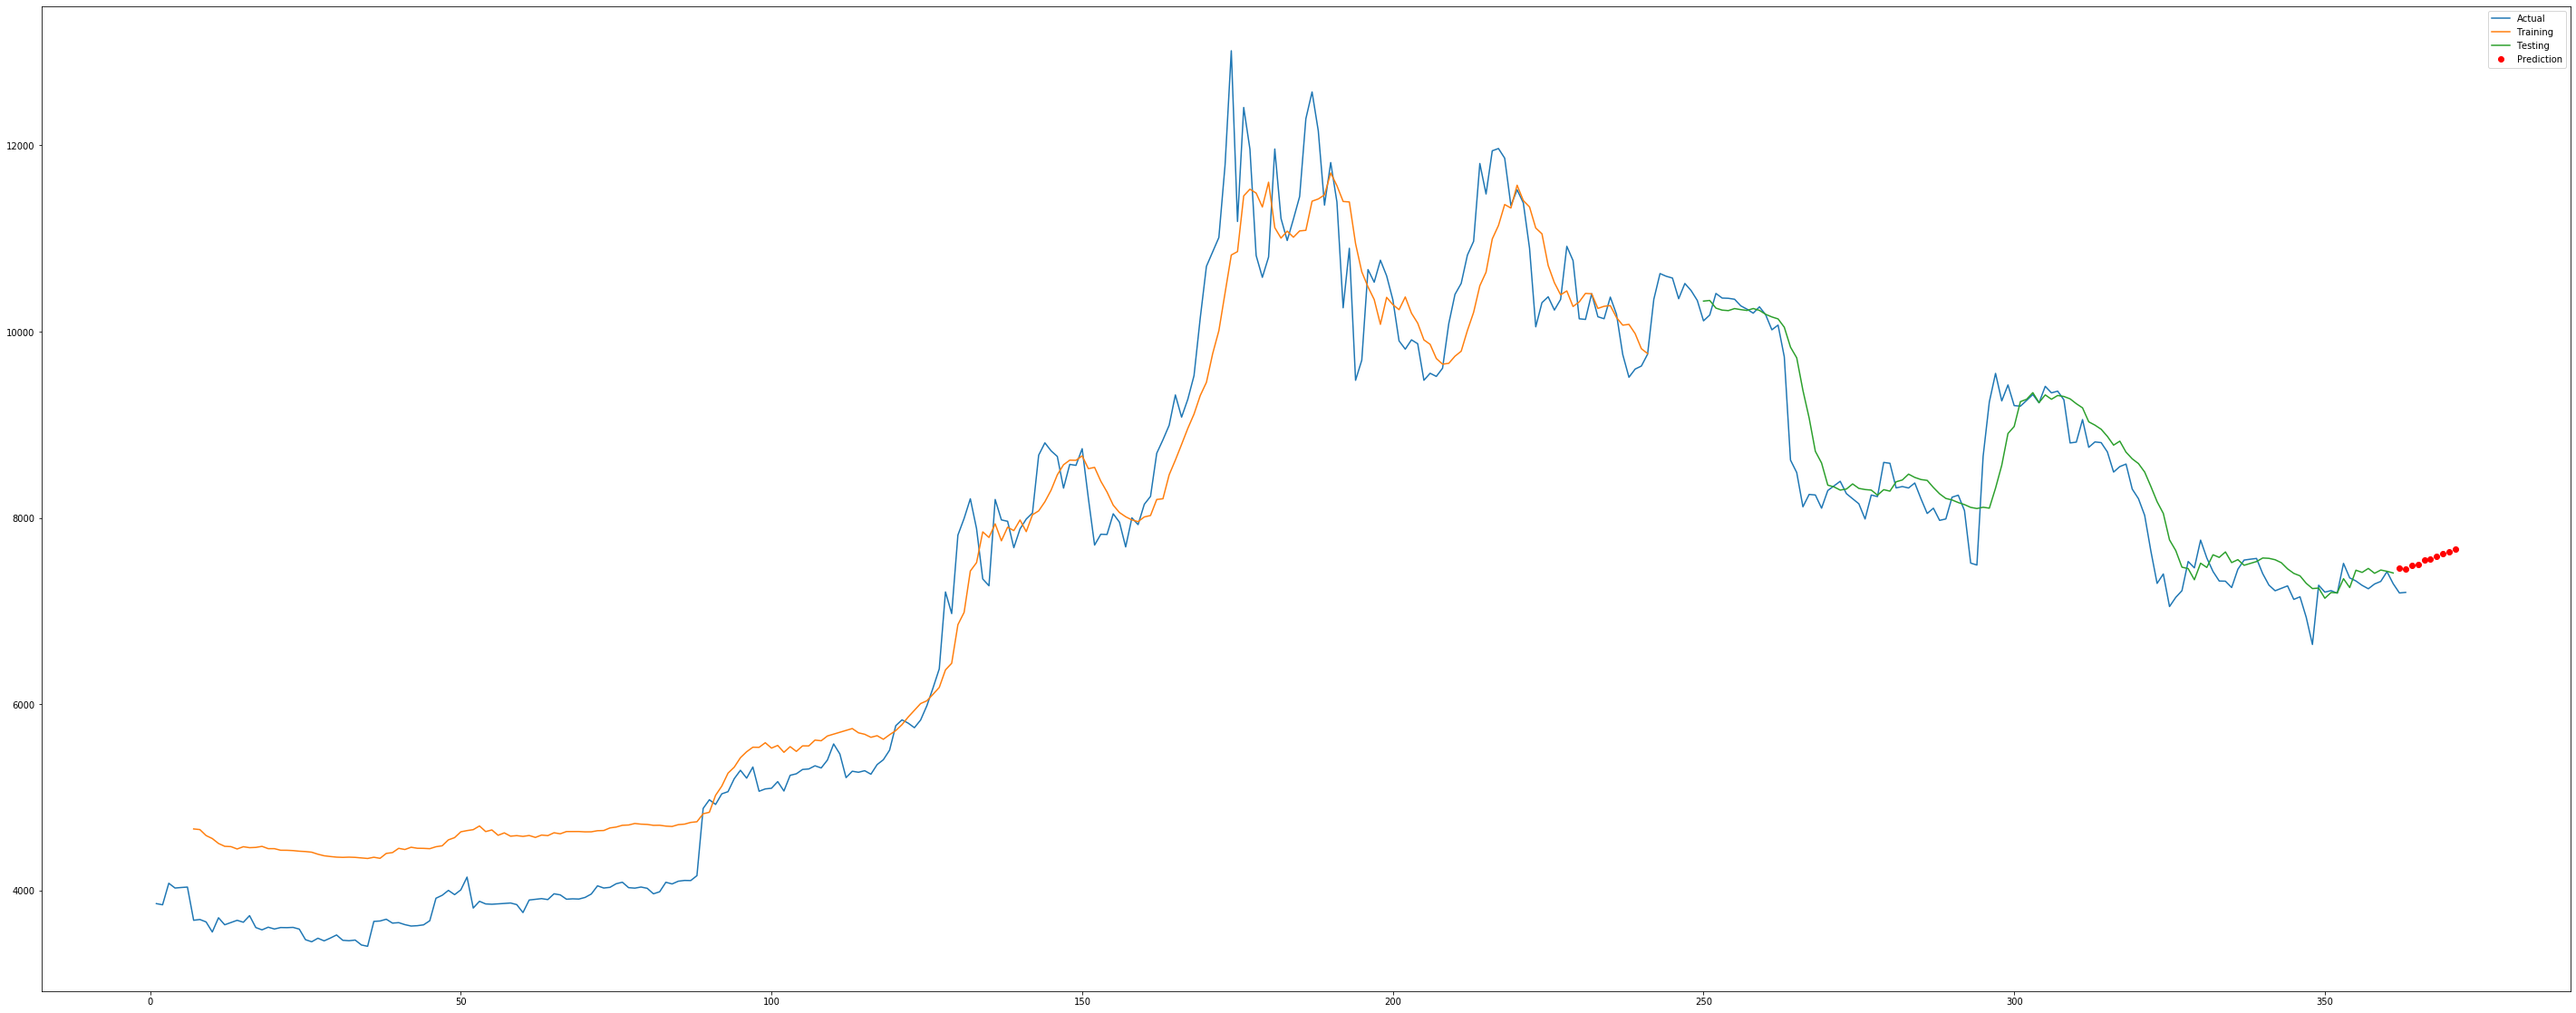

In [32]:
plt.figure(figsize=(50,20))
plt.plot(df['Last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"]).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"]).close, label='Testing')
plt.plot(pd.DataFrame(PredictionPlot, columns=["close"]).close, 'ro',label='Prediction')
plt.legend(loc='best')
plt.show()